# **Importing Libraries**

In [1]:
!apt-get install -qq openjdk-11-jdk-headless
!pip install -q pyspark==3.5.0
!wget -q https://repo1.maven.org/maven2/com/crealytics/spark-excel_2.12/3.5.0_0.20.3/spark-excel_2.12-3.5.0_0.20.3.jar -P /content/jars/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.7.5 requires pyspark[connect]~=3.5.1, but you have pyspark 3.5.0 which is incompatible.


In [52]:
from google.colab import drive
from pathlib import Path
from pyspark.sql import SparkSession
import os
from pyspark.sql import DataFrame
import zipfile
from functools import reduce
import pandas as pd
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import date_format, to_date
from pyspark.sql.functions import year, month, dayofweek, hour, count
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# **Reading and merging the dataset**

In [3]:
spark = (
    SparkSession.builder
      .appName("readingPreprocessing_con")
      .config("spark.driver.memory", "8g")
      .config("spark.executor.memory", "8g")
      .config("spark.jars", "/content/jars/spark-excel_2.12-3.5.0_0.20.3.jar")
      .getOrCreate()
)

print(" Spark session ready")

 Spark session ready


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
excel_path = "/content/drive/MyDrive/Consulting Labs x HTU"

In [6]:
excel_dir = Path("/content/drive/MyDrive/Consulting Labs x HTU")
xlsx_files = sorted(excel_dir.glob("*.xlsx"))

print(f"Found {len(xlsx_files)} Excel files:")
for f in xlsx_files:
    print("•", f.name)

Found 13 Excel files:
• 1) Jan-June 2022-unlock.xlsx
• 10) April-June-2024 unlock.xlsx
• 11) July-Sep-2024 unlock.xlsx
• 12) Oct-Dec-2024 unlock.xlsx
• 13)Jan-April-2025 unlock.xlsx
• 2 July-Sep 2022-unlock.xlsx
• 3) Oct-Dec 2022 - unlock.xlsx
• 4 Jan-March 2023-unlock.xlsx
• 5) April-June-2023 - unlock.xlsx
• 6) July-2023 unlock.xlsx
• 7) Aug-Sep-2023 unlock.xlsx
• 8) Oct-Dec-2023 unlock.xlsx
• 9)Jan-March-2024 unlock.xlsx


In [7]:
for path in xlsx_files:
    print(f" {path.name}")
    df = (
        spark.read.format("com.crealytics.spark.excel")
             .option("header", "false")
             .option("dataAddress", "'Sheet1'!A3")
             .option("inferSchema", "true")
             .load(str(path))
    )
    print(f"→ Total columns: {len(df.columns)}")
    df.limit(5).show()


 1) Jan-June 2022-unlock.xlsx
→ Total columns: 4
+-----+--------------------+--------------------+---+
|  _c0|                 _c1|                 _c2|_c3|
+-----+--------------------+--------------------+---+
|22011| 2022-04-02 14:37:47|                    |   |
|     |                    |                    |   |
|22012| 2022-04-16 20:50:46|                    |   |
|22012|Respiratory Profi...|SARS-COV2 (COVID1...|   |
|     |                    |                    |   |
+-----+--------------------+--------------------+---+

 10) April-June-2024 unlock.xlsx
→ Total columns: 3
+--------+--------------------+--------------------+
|     _c0|                 _c1|                 _c2|
+--------+--------------------+--------------------+
|24053969| 2024-04-01 09:53:02|                    |
|24053969|Creatinine Phosph...|Creatinine Phosph...|
|24053969| CK-MB Concentration|     CK-MB: 4.5 IU/L|
|        |                    |                    |
|24053970| 2024-04-01 10:01:37|          

In [8]:
def load_cleaned_tests(path):
    df = (
        spark.read.format("com.crealytics.spark.excel")
            .option("header", "false")
            .option("dataAddress", "'Sheet1'!A3")
            .option("inferSchema", "true")
            .load(str(path))
            .selectExpr("_c0 as patient_id", "_c1 as field", "_c2 as result")
            .filter("patient_id IS NOT NULL")
    )

    #  per patient_id
    window = Window.partitionBy("patient_id").orderBy("field")
    visit_times = (
        df.withColumn("visit_ts_raw", F.first("field").over(window))
          .withColumn("visit_ts", F.to_timestamp("visit_ts_raw"))
    )

    # Filter
    tests_only = (
        visit_times.filter("field != visit_ts_raw")
                   .selectExpr("patient_id", "field as test_name", "visit_ts")
                   .filter("test_name IS NOT NULL AND visit_ts IS NOT NULL")
    )

    return tests_only


In [9]:
# Merge
merged_df = None
valid_files = 0

for path in xlsx_files:
    try:
        df = load_cleaned_tests(path)
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.unionByName(df)
        valid_files += 1
    except Exception as e:
        print(f" Skipped {path.name}: {e}")

print(f" Successfully merged {valid_files} files")
merged_df.show(10)


 Successfully merged 13 files
+----------+--------------------+-------------------+
|patient_id|           test_name|           visit_ts|
+----------+--------------------+-------------------+
|    220110|Respiratory Profi...|2022-05-10 18:44:46|
|   2201100|Total Protein in ...|2022-06-15 13:32:41|
|   2201101|Growth Hormone st...|2022-06-15 13:43:11|
|   2201102|HBV - DNA Viral l...|2022-06-15 14:03:24|
|   2201102|Hepatitis B surfa...|2022-06-15 14:03:24|
|   2201102|Hepatitis B surfa...|2022-06-15 14:03:24|
|   2201103|Histopathology  r...|2022-06-14 15:57:15|
|   2201104|Histopathology re...|2022-06-14 16:00:24|
|   2201105|Histopathology re...|2022-06-14 16:05:10|
|   2201106|Histopathology re...|2022-06-14 16:07:33|
+----------+--------------------+-------------------+
only showing top 10 rows



# **Preprocessing the dataset**

In [13]:
# Filter nulls and extract time-based features
preprocessed_df = (
    merged_df
    .dropna(subset=["patient_id", "test_name", "visit_ts"])
    .withColumn("year", year("visit_ts"))
    .withColumn("month", month("visit_ts"))
    .withColumn("weekday", dayofweek("visit_ts"))
    .withColumn("hour", hour("visit_ts"))
    .withColumn("date", to_date("visit_ts"))
    .cache()
)

# Basic summary of test frequency
test_summary = (
    preprocessed_df.groupBy("test_name")
    .agg(count("*").alias("test_count"))
    .orderBy("test_count", ascending=False)
)

test_summary.show(10)

+--------------------+----------+
|           test_name|test_count|
+--------------------+----------+
|Complete Blood Co...|     16067|
|            Ferritin|      9608|
|Thyroid Stimulati...|      9555|
|        Vitamin B12 |      9350|
|Glycosylated Hemo...|      8925|
|      Urine Analysis|      8679|
|         Creatinine |      6092|
|          Vitamin D3|      5973|
|Fasting Blood Sug...|      5457|
|       Triglycerides|      4567|
+--------------------+----------+
only showing top 10 rows



In [14]:
monthly_demand = (
    preprocessed_df.groupBy("year", "month")
    .agg(count("*").alias("monthly_tests"))
    .orderBy("year", "month")
)

# Convert to pandas
pdf = monthly_demand.toPandas()
pdf["year_month"] = pdf["year"].astype(str) + "-" + pdf["month"].astype(str).str.zfill(2)

# **Visualisations and insights**

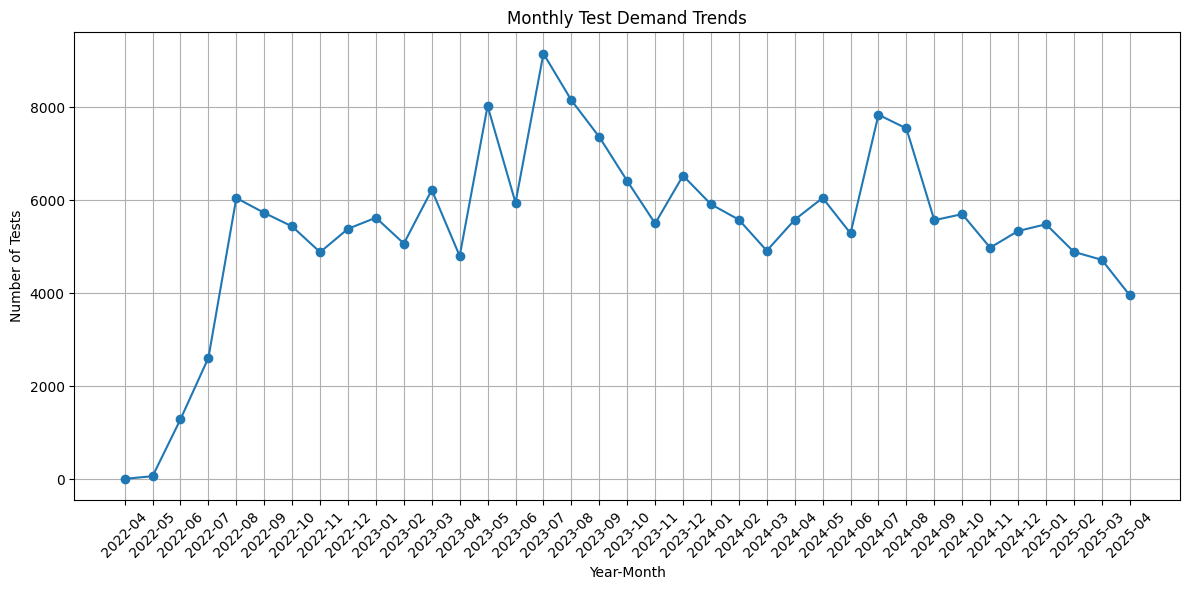

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(pdf["year_month"], pdf["monthly_tests"], marker='o')
plt.xticks(rotation=45)
plt.title("Monthly Test Demand Trends")
plt.xlabel("Year-Month")
plt.ylabel("Number of Tests")
plt.grid(True)
plt.tight_layout()
plt.show()

**

-Clear seasonal fluctuations with consistent spikes mid-year (June–July).

-Monthly demand started strong in mid-2022 and peaked in 2023, followed by a downward trend into early 2025.

-This could inform resource planning, predictive stock ordering, and forecast models for upcoming months.

**

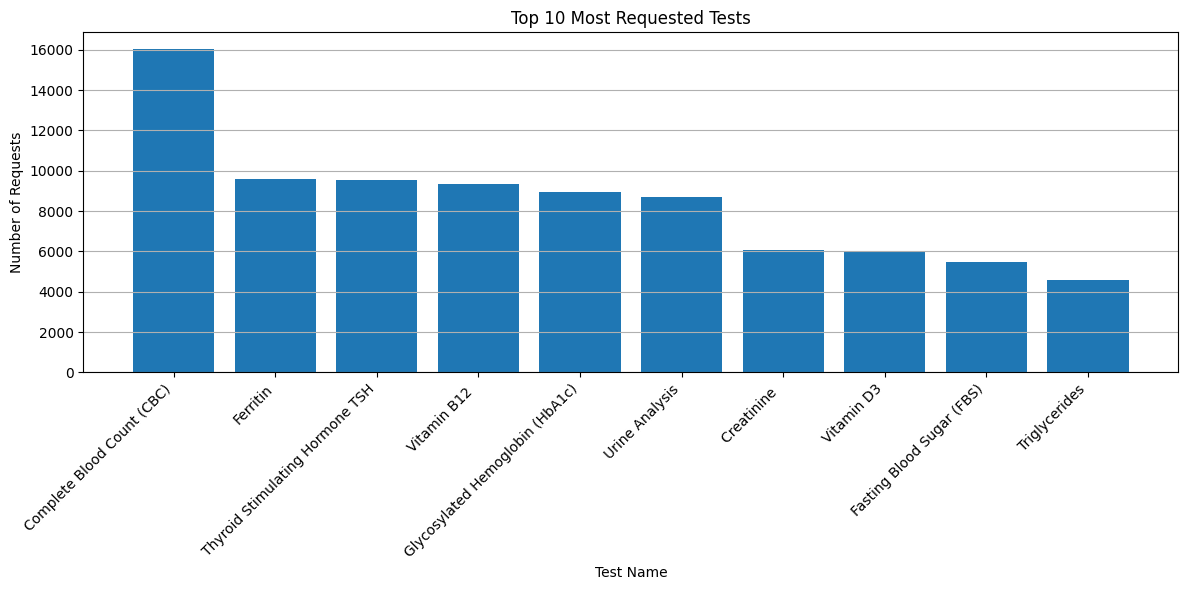

In [19]:
# Aggregate top 10 most frequent test names
top_tests_df = (
    preprocessed_df.groupBy("test_name")
    .agg(count("*").alias("test_count"))
    .orderBy("test_count", ascending=False)
    .limit(10)
)

top_tests_pdf = top_tests_df.toPandas()


plt.figure(figsize=(12, 6))
plt.bar(top_tests_pdf["test_name"], top_tests_pdf["test_count"])
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Most Requested Tests")
plt.xlabel("Test Name")
plt.ylabel("Number of Requests")
plt.tight_layout()
plt.grid(axis='y')
plt.show()

**

-Complete Blood Count (CBC) is by far the most requested test, followed by Ferritin and TSH.

-These top tests should be prioritized for inventory, automation, and marketing.

-Patterns can be used for test bundling promotions or targeted campaigns.

**

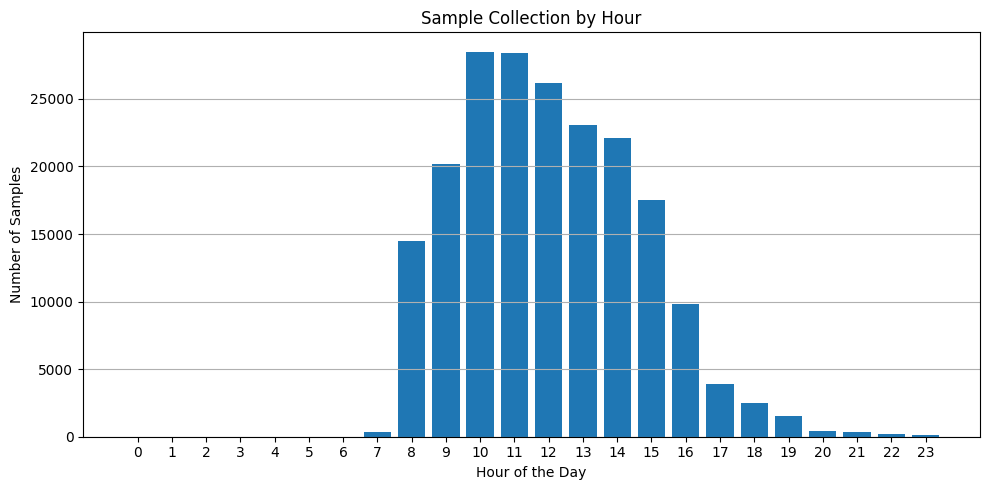

In [20]:
# Aggregate by hour
hourly_df = (
    preprocessed_df.groupBy("hour")
    .agg(count("*").alias("samples_collected"))
    .orderBy("hour")
)

hourly_pdf = hourly_df.toPandas()


plt.figure(figsize=(10, 5))
plt.bar(hourly_pdf["hour"], hourly_pdf["samples_collected"])
plt.xticks(range(0, 24))
plt.title("Sample Collection by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Samples")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**

-Most samples are collected between 9 AM and 1 PM, peaking at 10–11 AM.

-Very few samples are collected after 4 PM.

-Suggests that Consulting Labs could extend morning hours or introduce early appointment slots to better handle the peak load.

**

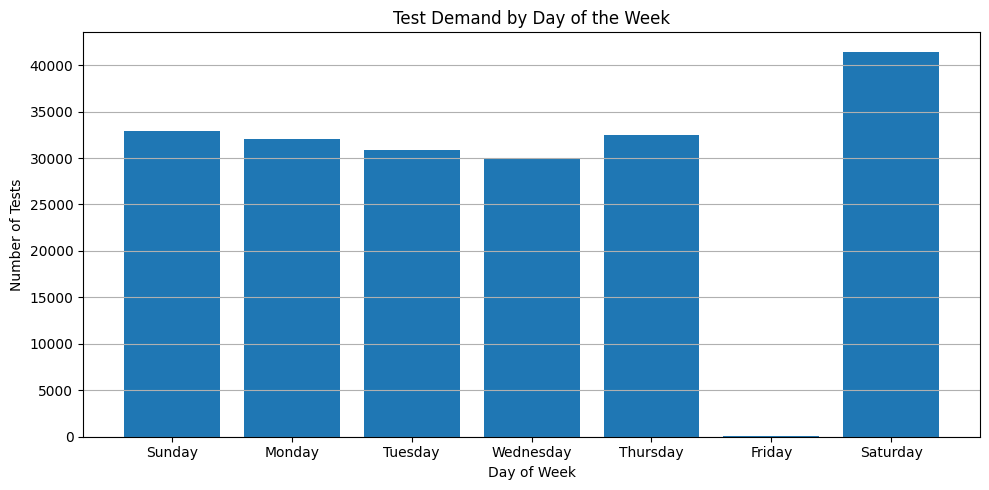

In [21]:
weekly_df = (
    preprocessed_df.groupBy("weekday")
    .agg(count("*").alias("weekly_tests"))
    .orderBy("weekday")
)

weekly_pdf = weekly_df.toPandas()
weekday_names = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
weekly_pdf["weekday"] = weekly_pdf["weekday"].apply(lambda x: weekday_names[x - 1])


plt.figure(figsize=(10, 5))
plt.bar(weekly_pdf["weekday"], weekly_pdf["weekly_tests"])
plt.title("Test Demand by Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Tests")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**

-Saturday is the busiest day, followed by Sunday and Thursday.

-Wednesday is the slowest day for testing. They can optimise this issue by giving offers or promotions in wednesday.

-This pattern can help optimize staff scheduling and promotions on low-traffic days like midweek.


**

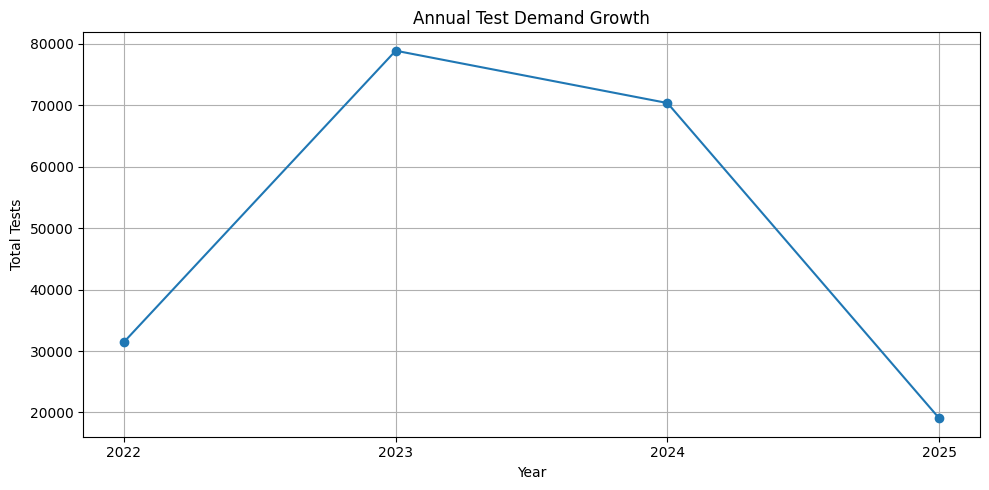

In [23]:
yearly_df = (
    preprocessed_df.groupBy("year")
    .agg(count("*").alias("yearly_tests"))
    .orderBy("year")
)

yearly_pdf = yearly_df.toPandas()


plt.figure(figsize=(10, 5))
plt.plot(yearly_pdf["year"].astype(str), yearly_pdf["yearly_tests"], marker='o')
plt.title("Annual Test Demand Growth")
plt.xlabel("Year")
plt.ylabel("Total Tests")
plt.grid(True)
plt.tight_layout()
plt.show()


**

-2023 was the peak year, with nearly 80,000 tests conducted.

-A noticeable drop in 2025 test demand, this may reflect incomplete data or reduced operations.

-Consulting Labs should investigate the causes of decline in 2024–2025 and explore retention, marketing, or capacity adjustments.

**

# **Prediction**

In [40]:
# Use the already aggregated monthly demand DataFrame
monthly_df = (
    preprocessed_df.groupBy("year", "month")
    .agg(count("*").alias("monthly_tests"))
    .orderBy("year", "month")
)

# Convert to Pandas
monthly_pdf = monthly_df.toPandas()

# Create numeric time feature like 202201, 202202, ...
monthly_pdf["time_index"] = monthly_pdf["year"] * 100 + monthly_pdf["month"]
X = monthly_pdf[["time_index"]].values
y = monthly_pdf["monthly_tests"].values


In [70]:
# Create and fit the model
tree_model = DecisionTreeRegressor(max_depth=7, random_state=42)
tree_model.fit(X, y)

# Predict
monthly_pdf["tree_predicted"] = tree_model.predict(X)


In [71]:
# Evaluation metrics
mae_tree = mean_absolute_error(y, monthly_pdf["tree_predicted"])
mse_tree = mean_squared_error(y, monthly_pdf["tree_predicted"])
rmse_tree = np.sqrt(mse_tree)
r2_tree = r2_score(y, monthly_pdf["tree_predicted"])

print(" Decision Tree Evaluation:")
print(f"🔸 MAE  = {mae_tree:.2f}")
print(f"🔸 MSE  = {mse_tree:.2f}")
print(f"🔸 RMSE = {rmse_tree:.2f}")
print(f"🔸 R²   = {r2_tree:.2f}")

 Decision Tree Evaluation:
🔸 MAE  = 94.25
🔸 MSE  = 36707.64
🔸 RMSE = 191.59
🔸 R²   = 0.99


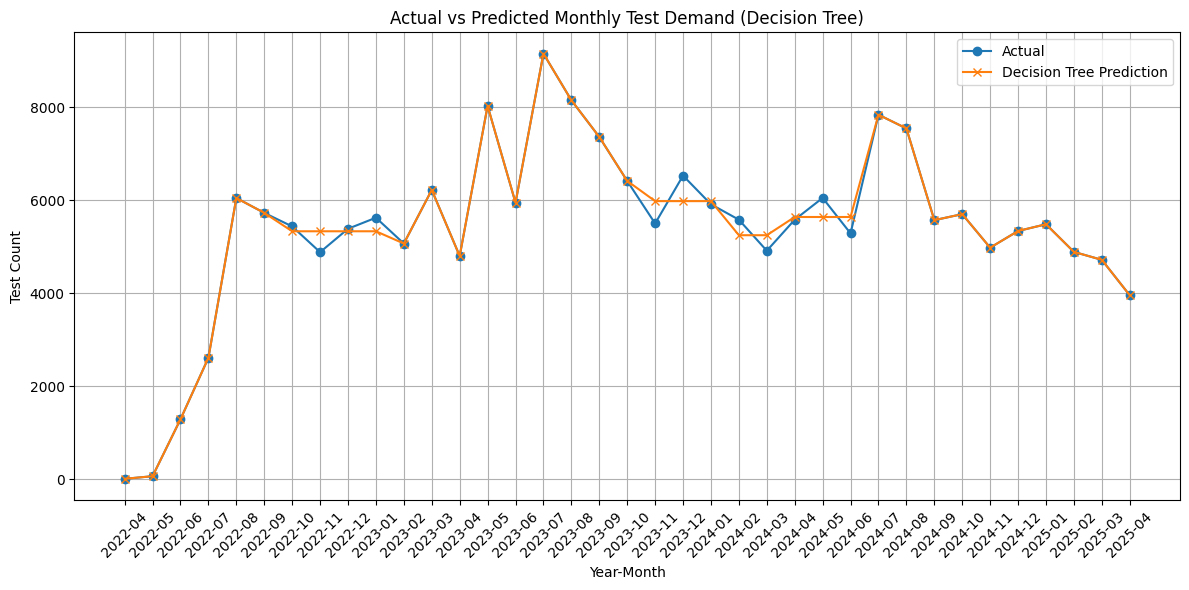

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_pdf["year_month"], y, label="Actual", marker='o')
plt.plot(monthly_pdf["year_month"], monthly_pdf["tree_predicted"], label="Decision Tree Prediction", marker='x')
plt.xticks(rotation=45)
plt.title("Actual vs Predicted Monthly Test Demand (Decision Tree)")
plt.xlabel("Year-Month")
plt.ylabel("Test Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
future = [[202505]]  # May 2025
future_pred_tree = tree_model.predict(future)
print(f"Predicted test demand for May 2025 (Tree): {int(future_pred_tree[0])} tests")


Predicted test demand for May 2025 (Tree): 3956 tests


In [74]:
# Predict for Mar–Dec 2025
future_months = [[202502 + i] for i in range(11)]
future_preds = tree_model.predict(future_months)

for i, value in enumerate(future_preds):
    print(f"2025-{str(2+i).zfill(2)}: {int(value)} tests expected")


2025-02: 4890 tests expected
2025-03: 4719 tests expected
2025-04: 3956 tests expected
2025-05: 3956 tests expected
2025-06: 3956 tests expected
2025-07: 3956 tests expected
2025-08: 3956 tests expected
2025-09: 3956 tests expected
2025-10: 3956 tests expected
2025-11: 3956 tests expected
2025-12: 3956 tests expected
